<a href="https://colab.research.google.com/github/amirkasaei/NLP-An-Odd-Music-Generator/blob/main/NLP_An_Odd_Music_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

---



## **imports**

In [ ]:
pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, MaxPooling1D, GlobalMaxPool1D, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Embedding
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from copy import deepcopy
from __future__ import unicode_literals
from scipy.io import wavfile
import scipy.signal as sps
import librosa

## **Google drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Helper functions**

In [ ]:
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

def outputResult(model, history, X_train, y_train, X_test, y_test, noteDict):
  # print("result in training set:", "\ntrain acc= ",
  #       self.history['accuracy'], "\ntrain loss= ", self.history['loss'])
  # print("\nresult in test set:", "\ntest acc= ",
  #       self.history['val_accuracy'], "\ntest loss= ", self.history['val_loss'], '\n')

  # best models based on acc or loss in tarin set or test set
  trainHistory = list(
      map(lambda x, y: [x, y], history['accuracy'], history['loss']))
  testHistory = list(
      map(lambda x, y: [x, y], history['val_accuracy'], history['val_loss']))
  print(
      f"\nbest model based on min training set loss:  acc= {min(trainHistory, key = lambda k: k[1])[0]}  loss= {min(trainHistory, key = lambda k: k[1])[1]}")
  print(
      f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
  print(
      f"best model based on max training set accuracy:  acc= {max(trainHistory, key = lambda k: k[0])[0]}  loss= {max(trainHistory, key = lambda k: k[0])[1]}")
  print(
      f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

  print("\nevaluate dataset with best model based on maximum test set accuracy")
  print("evaluate train set= ", model.evaluate(
      X_train, y_train, verbose=0))
  print("evaluate test set= ", model.evaluate(X_test, y_test, verbose=0))

  y_train_pred = model.predict(X_train)
  # convert probablities to 0s and 1s
  y_train_pred = argmaxKeepDimensions(y_train_pred)

  y_test_pred = model.predict(X_test)
  # convert probablities to 0s and 1s
  y_test_pred = argmaxKeepDimensions(y_test_pred)

  # confusion matrix and precision, recall and f1 report
  print('\n', '-'*30, 'metrics for traning set', '-'*30)

  print("confusion matrix: \n", metrics.confusion_matrix(
      np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
  print(metrics.classification_report(y_train,
        y_train_pred, digits=3, target_names=list(noteDict.keys())))

  # confusion matrix and precision, recall and f1 report
  print('-'*30, 'metrics for test set', '-'*30)
  
  print("confusion matrix: \n", metrics.confusion_matrix(
      np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))
  print(metrics.classification_report(y_test,
        y_test_pred, digits=3, target_names=list(noteDict.keys())))
  
  # self.model.summary()


In [ ]:
def showPlots(model, history):
    plt.plot(history['accuracy'],
              label='training accuracy', marker='.', color='green')
    plt.plot(history['val_accuracy'],
              label='test accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history['loss'],
              label='training loss', marker='.', color='green')
    plt.plot(history['val_loss'],
              label='test loss', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **Denoising Network**

## **Preprocessing**

In [ ]:
sample_rate = 4000  # sample rate

**Paths**

In [ ]:
notesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_triads'
noisesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/artifacts'
songsPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_pieces'

**Helper Functions**

In [ ]:
# mix piece and noise together
def AddNoiseToPiece(piece, noise, noise_factor):
  noisy_piece = piece + (noise_factor*noise)
  return noisy_piece

# append wav np.array of notes by having note names in a piece
def appendNotes(piece, notes, notesLabel): 
  appendedNotes = []
  for piece_note in piece:
    index = notesLabel.index(piece_note)
    appendedNotes.extend(notes[index])
  return np.array(appendedNotes)

# add padding to wav piece to grow up its length to max_length
def addPadding(piece_wav):
  max_length = sample_rate * 9
  return np.pad(piece_wav, (0,max_length-piece_wav.shape[0]))

# split np.array to multiple specific length array 
def splitToSpecificLength(arr, length):
  arr = np.array(arr)
  numberOfPiece = arr.shape[0]//length + 1 if arr.shape[0]%length != 0 else arr.shape[0]//length
  return np.split(arr, [length*i for i in range(1, numberOfPiece)])

**Read all notes and noise**

In [ ]:
notes, notesLabel, noises = [], [], []
for note in os.listdir(notesPath):
  data  = librosa.load(notesPath+'/'+note, sr=sample_rate, dtype=np.float32)[0]
  notes.append(data)
  notesLabel.append(note[:-4])

for noise in os.listdir(noisesPath):
  # noises must have 1/3 note sample rate because their length are 3X
  noises.append(librosa.load(noisesPath + '/'+ noise, sr=sample_rate, dtype=np.float32)[0]) # sample rate for a 9s song: 1 noises per song

notes = np.array(notes)
noises = np.array(noises)
# notesLabel = np.array(notesLabel)
print(notes.shape)
print(noises.shape)

(432, 12000)
(42, 36000)


**Read all song notes**

In [ ]:
songs = []
for song in os.listdir(songsPath):
  data  = open(songsPath + '/' + song, 'r')
  data = data.readlines()
  if data:
    songs.append(data[0].split(' / '))

**Estimate number of dataset**

In [ ]:
def estimateNumberOfSamples(songs, i, j):
  numberOfNoises = 40

  songsLength = [len(x) for x in songs]
  songsLength = np.array(songsLength)
  numberOfPiecesPerSong = np.ceil(songsLength/3)

  #print(numberOfPiecesPerSong[0])
  numberOfPieces = np.sum(numberOfPiecesPerSong[i : j])
  numberOfSamples = numberOfPieces * numberOfNoises

  return numberOfSamples

estimateNumberOfSamples(songs, 0, 1)

1240.0

In [ ]:
appendNotes(songs[0][:3], notes, notesLabel).shape

(36000,)

**DAE Data Generator**

In [ ]:
def DAE_data_generator(songs, batchsize):
    X_DAE_batch, y_DAE_batch = [], []
    batchcount = 0
    while True:
        for song in songs:
          # separate the notes of song with 30 length
          song_pieces = splitToSpecificLength(song, 10) + splitToSpecificLength(song, 20)# + splitToSpecificLength(song, 4) + splitToSpecificLength(song, 5) + splitToSpecificLength(song, 20) + splitToSpecificLength(song, 30)
          
          # create all pieces in the song
          for piece in song_pieces:
              piece_wav = appendNotes(piece, notes, notesLabel)
              piece_wav_pad = addPadding(piece_wav)
              for noise in noises:
                noisy_piece_wav = AddNoiseToPiece(piece_wav_pad, noise, 0.25)

                X_DAE_batch.append(noisy_piece_wav)
                # X_DAE_batch.append(piece_wav_pad)
                y_DAE_batch.append(piece_wav_pad)

                batchcount += 1
                if batchcount == batchsize:
                  X_DAE_batch = np.array(X_DAE_batch)
                  y_DAE_batch = np.array(y_DAE_batch)
                  
                  yield (X_DAE_batch, y_DAE_batch)
                  X_DAE_batch = []
                  y_DAE_batch = []
                  batchcount = 0

In [ ]:
def DAE_data_generator1(songs, batchsize):
    X_DAE_batch, y_DAE_batch = [], []
    batchcount = 0
    while True:
        for song in songs[:5]:
          # separate the notes of song with 3 length
          song_pieces = splitToSpecificLength(song, 3)# + splitToSpecificLength(song, 4) + splitToSpecificLength(song, 5) + splitToSpecificLength(song, 20) + splitToSpecificLength(song, 30)
          
          # create all pieces in the song
          for piece in song_pieces:
              piece_wav = appendNotes(piece, notes, notesLabel)
              piece_wav_pad = addPadding(piece_wav)
              for noise in noises:
                noisy_piece_wav = AddNoiseToPiece(piece_wav_pad, noise, 0.25)

                X_DAE_batch.append(noisy_piece_wav)
                # X_DAE_batch.append(piece_wav_pad)
                y_DAE_batch.append(piece_wav_pad)

                batchcount += 1
                if batchcount == batchsize:
                  X_DAE_batch = np.array(X_DAE_batch)
                  y_DAE_batch = np.array(y_DAE_batch)
                  
                  yield (X_DAE_batch, y_DAE_batch)
                  X_DAE_batch = []
                  y_DAE_batch = []
                  batchcount = 0

## **Implementation**

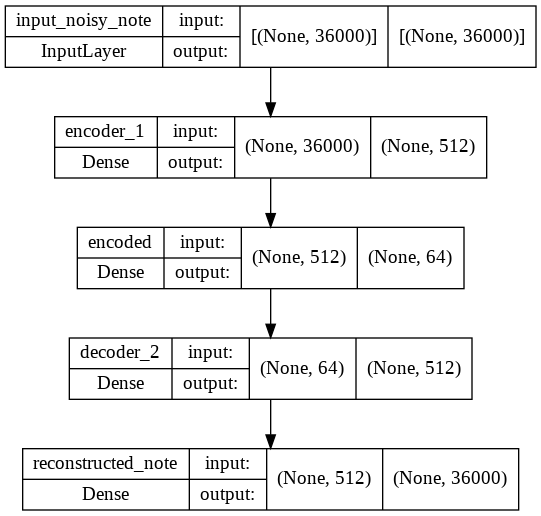

In [ ]:
batchsize = 200 #720

inputShape = ouputShape = 36000

input = Input(shape=(inputShape, ), name="input_noisy_note")

# x = tf.keras.layers.Conv1D(1, 500, strides=100, activation='linear')(input)
# x = tf.keras.layers.Flatten()(x)
x = Dense(512, activation='relu', name="encoder_1")(input)
# x = Dense(128, activation='linear', name="encoder_2")(x)
# x = Dense(32, activation='tanh', name="encoder_3")(x)
x = Dense(64, activation='linear', name="encoded")(x)
# x = Dense(32, activation='tanh', name="decoder_1")(x)
# x = Dense(128, activation='linear', name="decoder_1")(x)
x = Dense(512, activation='linear', name="decoder_2")(x)
out = Dense(ouputShape, activation='linear', name="reconstructed_note")(x)

DAE_model = Model(inputs=input, outputs=out)

# Compile the Model
metrics = ['mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity']
DAE_model.compile(loss="mean_squared_error", optimizer=Adam(0.01), metrics=metrics)

filepath = '/content/drive/MyDrive/Deep Learning/Music Generator/DAE_best_model_test.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

plot_model(DAE_model, to_file="DAE_model.png", show_shapes=True)

In [ ]:
filepath_old = '/content/drive/MyDrive/Deep Learning/Music Generator/DAE_best_model_3.hdf5'

with tf.device('/GPU:0'):
  # DAE_model = load_model(filepath_old)
  DAE_history = DAE_model.fit(DAE_data_generator1(songs, batchsize), steps_per_epoch=estimateNumberOfSamples(songs, 0, 5)/batchsize, epochs=1000, callbacks=[checkpoint]).history
  DAE_model = load_model(filepath)

Epoch 1/1000
27/27 [==============================] - 4s 145ms/step - loss: 0.0010 - mean_absolute_error: 0.0171 - mean_squared_logarithmic_error: 4.0314e-04 - cosine_similarity: 0.1474
Epoch 2/1000
27/27 [==============================] - 4s 159ms/step - loss: 9.7897e-04 - mean_absolute_error: 0.0177 - mean_squared_logarithmic_error: 3.7769e-04 - cosine_similarity: 0.2177
Epoch 3/1000
27/27 [==============================] - 2s 82ms/step - loss: 0.0030 - mean_absolute_error: 0.0289 - mean_squared_logarithmic_error: 0.0010 - cosine_similarity: 0.1476
Epoch 4/1000
27/27 [==============================] - 2s 83ms/step - loss: 20.0144 - mean_absolute_error: 1.8811 - mean_squared_logarithmic_error: 0.4962 - cosine_similarity: 0.0052
Epoch 5/1000
27/27 [==============================] - 2s 83ms/step - loss: 609.1896 - mean_absolute_error: 12.1340 - mean_squared_logarithmic_error: 2.3794 - cosine_similarity: 0.0012
Epoch 6/1000
27/27 [==============================] - 3s 97ms/step - loss: 30

In [ ]:
DAE_model = load_model(filepath)

In [ ]:
X_test = songs[0]
pieces = 3
song_pieces = splitToSpecificLength(X_test, pieces)
X_test = song_pieces[15]
X_test_wav = appendNotes(X_test, notes, notesLabel)
X_test_pad = addPadding(X_test_wav)
X_test = AddNoiseToPiece(X_test_pad, noises[16], 0.25)
#X_test = X_test_pad
wavfile.write('input.wav', sample_rate, X_test)

y_test_true = X_test_pad
X_test = np.array([X_test])
y_test_pred = DAE_model.predict(X_test)


print('X_test= ', X_test[0])
print('y_test_true= ', y_test_true)
print('y_test_pred= ', y_test_pred[0])

wavfile.write('output_true.wav', sample_rate, y_test_true)
wavfile.write('output_pred.wav', sample_rate, y_test_pred[0])


differention = np.subtract(y_test_pred[0], y_test_true)
print('differention= ', differention)

# y_pred = DAE_model.predict(X_test)
# wavfile.write('pred.wav', 4200, y_pred[0])

X_test=  [-0.00090682 -0.02104415  0.02712481 ...  0.00014189 -0.00020377
 -0.00030586]
y_test_true=  [ 0.00558981 -0.01113711  0.02105595 ...  0.00012396  0.00011809
  0.00010467]
y_test_pred=  [-0.04421364  0.20197463 -0.2910446  ... -0.11576898 -0.0268769
 -0.27270103]
differention=  [-0.04980345  0.21311174 -0.31210056 ... -0.11589294 -0.02699499
 -0.2728057 ]


# **Note Recognition**

## **Preprocessing**

**Read Note name from Piano Triads folder**

In [ ]:
notesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_triads'

In [ ]:
note = []
noteLabel = []
noteDic = {}
sample_rate = 4000
i = 0
for filename in os.listdir(notesPath):
  # data = sps.resample(wavfile.read(path+'/'+filename)[1], note_sample_rate)
  data = librosa.load(notesPath + '/'+ filename, sr=sample_rate, dtype=np.float32)[0]
  note.append(data)
  noteLabel.append(filename[:-4])
  noteDic[filename[:-4]] = i
  i += 1

note = np.array(note)
noteLabel = np.array(noteLabel)

note.shape, noteLabel.shape

((432, 12000), (432,))

In [ ]:
# create y true for each note
# A_dim_2_0
y_true_NR = []

for label in noteLabel:
  labelEncoded = noteDic[label]
  labelEncoded_HOT = to_categorical(labelEncoded, num_classes=len(noteDic))
  y_true_NR.append(labelEncoded_HOT)

y_true_NR = np.array(y_true_NR)

X_NR = note

y_true_NR.shape

(432, 432)

### **Data Augmentation**

#### **Noise Injection**

**medium noise**

In [ ]:
y_true_NR_aug = y_true_NR
for i in range(len(note)):
  noise = np.random.randn(len(note[i]))*0.01
  X_NR = np.append(X_NR, [noise+note[i]], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((864, 12000), (864, 432))

**high noise**

In [ ]:
for i in range(len(note)):
  noise = np.random.randn(len(note[i]))*0.02
  X_NR = np.append(X_NR, [noise+note[i]], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((1296, 12000), (1296, 432))

In [ ]:
for i in range(len(note)):
  noise = np.random.randn(len(note[i]))*0.015
  X_NR = np.append(X_NR, [noise+note[i]], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((1728, 12000), (1728, 432))

**low noise**

In [ ]:
for i in range(len(note)):
  noise = np.random.randn(len(note[i]))*0.005
  X_NR = np.append(X_NR, [noise+note[i]], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((2160, 12000), (2160, 432))

####**Changing Pitch**

**low pitch shift**

In [ ]:
for i in range(len(note)):
  data = librosa.effects.pitch_shift(note[i], sample_rate, n_steps=12)
  X_NR = np.append(X_NR, [data], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((2592, 12000), (2592, 432))

**high pitch shift**

In [ ]:
for i in range(len(note)):
  data = librosa.effects.pitch_shift(note[i], sample_rate, n_steps=20)
  X_NR = np.append(X_NR, [data], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((3024, 12000), (3024, 432))

#### **Change Volume**

**increase volume**

In [ ]:
for i in range(len(note)):
  X_NR = np.append(X_NR, [note[i]*1.5], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((3456, 12000), (3456, 432))

**decrease volume**

In [ ]:
for i in range(len(note)):
  X_NR = np.append(X_NR, [note[i]*0.5], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((3888, 12000), (3888, 432))

In [ ]:
for i in range(len(note)):
  X_NR = np.append(X_NR, [note[i]*0.75], axis=0)
  y_true_NR_aug = np.append(y_true_NR_aug, [y_true_NR[i]], axis=0)

X_NR.shape, y_true_NR_aug.shape

((4320, 12000), (4320, 432))

### **Split Dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_NR, y_true_NR_aug, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3456, 12000), (3456, 432), (864, 12000), (864, 432))

## **Implementation**

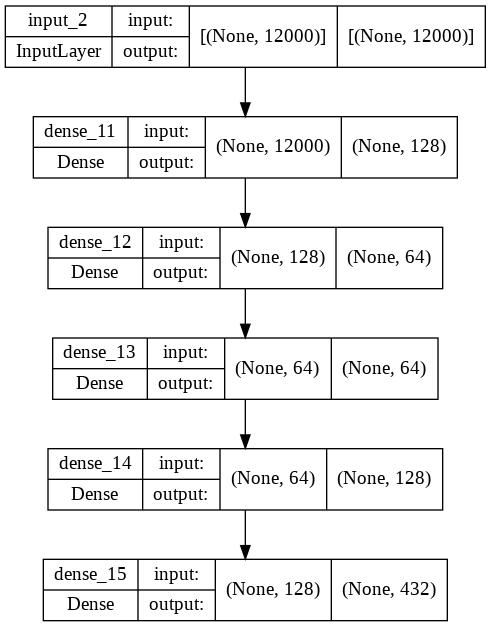

In [ ]:
input = Input(shape=(X_NR.shape[1],))
x = Dense(128, activation='relu')(input)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='sigmoid')(x)
out = Dense(432, activation="softmax")(x)

NR_model = Model(inputs=input, outputs=out)

# Compile the Model
NR_model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

filepath = '/content/drive/MyDrive/Deep Learning/Music Generator/NR_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='accuracy',
                              verbose=0,
                              save_best_only=True,
                              mode='max')

plot_model(NR_model, to_file="NR_model.png", show_shapes=True)

## **NR Model**

Epoch 1/100
54/54 - 2s - loss: 6.1425 - accuracy: 0.0052 - val_loss: 6.0642 - val_accuracy: 0.0104 - 2s/epoch - 36ms/step
Epoch 2/100
54/54 - 1s - loss: 5.8021 - accuracy: 0.0648 - val_loss: 5.7349 - val_accuracy: 0.0613 - 1s/epoch - 21ms/step
Epoch 3/100
54/54 - 1s - loss: 5.2617 - accuracy: 0.1875 - val_loss: 5.1700 - val_accuracy: 0.1586 - 1s/epoch - 22ms/step
Epoch 4/100
54/54 - 1s - loss: 4.5614 - accuracy: 0.3449 - val_loss: 4.5196 - val_accuracy: 0.2882 - 1s/epoch - 24ms/step
Epoch 5/100
54/54 - 2s - loss: 3.8418 - accuracy: 0.4890 - val_loss: 3.8698 - val_accuracy: 0.4051 - 2s/epoch - 35ms/step
Epoch 6/100
54/54 - 2s - loss: 3.2049 - accuracy: 0.5885 - val_loss: 3.2924 - val_accuracy: 0.4896 - 2s/epoch - 35ms/step
Epoch 7/100
54/54 - 1s - loss: 2.6536 - accuracy: 0.6826 - val_loss: 2.8075 - val_accuracy: 0.5486 - 1s/epoch - 22ms/step
Epoch 8/100
54/54 - 1s - loss: 2.2154 - accuracy: 0.7494 - val_loss: 2.4108 - val_accuracy: 0.6215 - 1s/epoch - 22ms/step
Epoch 9/100
54/54 - 1s -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


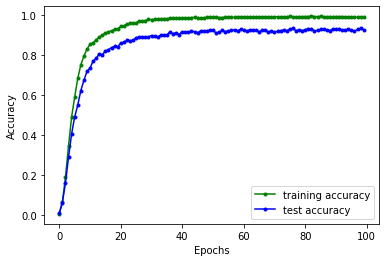

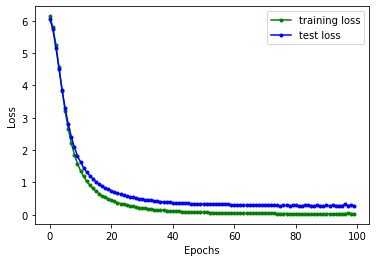

In [ ]:
with tf.device('/GPU:0'):
  NR_history = NR_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=100, verbose=2, callbacks=[checkpoint]).history
  NR_model = load_model(filepath)
  outputResult(NR_model, NR_history, X_train, y_train, X_test, y_test, noteDic)
  showPlots(NR_model, NR_history)

In [ ]:
with tf.device('/GPU:0'):
  NR_history = NR_model.fit(X_NR, y_true_NR_aug, batch_size=64, epochs=100, verbose=2, callbacks=[checkpoint]).history
  NR_model = load_model(filepath)


Epoch 1/100
68/68 - 3s - loss: 6.1153 - accuracy: 0.0060 - 3s/epoch - 42ms/step
Epoch 2/100
68/68 - 4s - loss: 5.6587 - accuracy: 0.0799 - 4s/epoch - 53ms/step
Epoch 3/100
68/68 - 2s - loss: 4.9076 - accuracy: 0.2632 - 2s/epoch - 34ms/step
Epoch 4/100
68/68 - 2s - loss: 4.0415 - accuracy: 0.4757 - 2s/epoch - 27ms/step
Epoch 5/100
68/68 - 2s - loss: 3.2564 - accuracy: 0.6086 - 2s/epoch - 28ms/step
Epoch 6/100
68/68 - 2s - loss: 2.6052 - accuracy: 0.7104 - 2s/epoch - 29ms/step
Epoch 7/100
68/68 - 2s - loss: 2.0947 - accuracy: 0.7713 - 2s/epoch - 28ms/step
Epoch 8/100
68/68 - 2s - loss: 1.7116 - accuracy: 0.8201 - 2s/epoch - 28ms/step
Epoch 9/100
68/68 - 2s - loss: 1.4137 - accuracy: 0.8463 - 2s/epoch - 27ms/step
Epoch 10/100
68/68 - 2s - loss: 1.1889 - accuracy: 0.8713 - 2s/epoch - 27ms/step
Epoch 11/100
68/68 - 2s - loss: 1.0140 - accuracy: 0.8838 - 2s/epoch - 28ms/step
Epoch 12/100
68/68 - 2s - loss: 0.8689 - accuracy: 0.9044 - 2s/epoch - 27ms/step
Epoch 13/100
68/68 - 2s - loss: 0.753

# **Note Prediction**

## **Preprocessing**

In [ ]:
sample_rate = 4000  # sample rate

**Paths**

In [ ]:
songsPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_pieces'
notesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_triads'

**Note encoding**

In [ ]:
noteLabel = {}
noteLabel['NA'] = 0 # NO note code
noteLabel['START'] = 1 # start note code
noteLabel['END'] = 2 # start note code

i = 3

for filename in os.listdir(notesPath): # notes code
  noteLabel[filename[:-4]] = i
  i+=1


**Helper Functions**

In [ ]:
# add padding to piece to grow up its length to max_length
def addPadding(piece):
  piece = np.array(piece)
  max_length = 31
  return np.pad(piece, (0,max_length-piece.shape[0]))

# split np.array to multiple specific length array 
def splitToSpecificLength(arr, length):
  arr = np.array(arr)
  numberOfPiece = arr.shape[0]//length + 1 if arr.shape[0]%length != 0 else arr.shape[0]//length
  return np.split(arr, [length*i for i in range(1, numberOfPiece)])

# Generate Dataset with specific length for Note Prediction 
def generateXYForSpecificNumberOfNotes(song, length):
  arr = splitToSpecificLength(song, length)
  NP_XY = [(['START'] + list(arr[i]), arr[i+1][0]) for i in range(len(arr)-1)]
  NP_XY.append((['START'] + list(arr[-1]), 'END'))
  return NP_XY


**Read all song notes**

In [ ]:
songs = []
for song in os.listdir(songsPath):
  data  = open(songsPath + '/' + song, 'r')
  data = data.readlines()
  if data:
    songs.append(data[0].split(' / '))

In [ ]:
len(noteLabel)

435

**Estimate number of dataset**

In [ ]:
songsLength = [len(x) for x in songs]
songsLength = np.array(songsLength)
numberOfPiecesPerSong = np.ceil(songsLength/3) + np.ceil(songsLength/4) #+ np.ceil(songsLength/5) + np.ceil(songsLength/6)\
                     #+ np.ceil(songsLength/7) + np.ceil(songsLength/8) 

numberOfPieces = np.sum(numberOfPiecesPerSong)

print(numberOfPieces)

21995.0


**NP(S2S) Data Generator**

In [ ]:
XY_NP = generateXYForSpecificNumberOfNotes(songs[0], 3)

X_NP = [x[0] for x in XY_NP]
y_true_NP = [x[1] for x in XY_NP]

print(X_NP[15])
print('-' * 100)
print(y_true_NP[15])

['START', 'Eb_min_5_0', 'Cs_maj_6_0', 'Cs_maj_7_1']
----------------------------------------------------------------------------------------------------
B_maj_7_1


In [ ]:
# test one hot
x0 = X_NP[15]

y0 = y_true_NP[15]

x0 = [noteLabel[n] for n in x0]
x0_pad = addPadding(x0)
y0 = noteLabel[y0]

x0_hot = to_categorical(x0_pad, num_classes=len(noteLabel))
y0_hot = to_categorical(y0, num_classes=len(noteLabel))
x0_hot.shape, y0_hot.shape

((31, 435), (435,))

In [ ]:
def NP_data_generator(songs, batchsize):
  X_NP_batch, y_NP_batch = [], []
  batchcount = 0
  while True:
    for song in songs:
      # separate the notes of song with 30 length
      XY_NP = generateXYForSpecificNumberOfNotes(song, 3) + generateXYForSpecificNumberOfNotes(song, 4) 
            # + generateXYForSpecificNumberOfNotes(song, 5) + generateXYForSpecificNumberOfNotes(song, 5) \
            # + generateXYForSpecificNumberOfNotes(song, 7) + generateXYForSpecificNumberOfNotes(song, 8) \

      
      # create all pieces in the song
      for sample in XY_NP:
        # sample[0] => X_NP
        # sample[1] => y_NP
        X_sample = [noteLabel[note] for note in sample[0]]
        y_sample = noteLabel[sample[1]]
        #print(y_sample)


        X_sample_pad = addPadding(X_sample) # Add padding and grow its length up to 780

        # make X and Y One Hot
        X_sample_HOT = to_categorical(X_sample_pad, num_classes=len(noteLabel))
        y_sample_HOT = to_categorical(y_sample, num_classes=len(noteLabel))

        X_NP_batch.append(X_sample_HOT)
        y_NP_batch.append(y_sample_HOT)
        
        batchcount += 1
        if batchcount > batchsize:
          X_NP_batch = np.array(X_NP_batch)
          y_NP_batch = np.array(y_NP_batch)
          yield (X_NP_batch, y_NP_batch)
          X_NP_batch = []
          y_NP_batch = []
          batchcount = 0

## **Implementation**

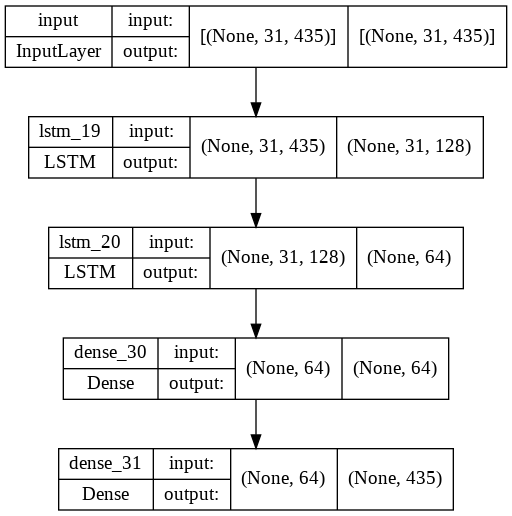

In [ ]:
batchsize = 250
NPInputShape = (31, 435)

input = Input(shape=NPInputShape, name="input")

l = LSTM(128, activation="relu", return_sequences=True)(input)
l = LSTM(64, activation="relu")(l)

d = Dense(64, activation="relu")(l)

output = Dense(NPInputShape[1], activation="softmax")(d)

NP_model = Model(inputs=input, outputs=output)

# Compile the Model
NP_model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

filepath = '/content/drive/MyDrive/Deep Learning/Music Generator/NP_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='accuracy',
                              verbose=0,
                              save_best_only=True,
                              mode='max')
                              
plot_model(NP_model, to_file="NP_model.png", show_shapes=True)

In [ ]:
with tf.device('/GPU:0'):
  NP_history = NP_model.fit(NP_data_generator(songs, batchsize), steps_per_epoch=numberOfPieces/batchsize, epochs=50, callbacks=[checkpoint]).history
  NP_model = load_model(filepath)
  # outputResult(NP_model, NP_history, X_train, y_train, X_test, y_test, noteDic)
  # showPlots(NP_model, NP_history)

Epoch 1/50
87/87 [==============================] - 34s 331ms/step - loss: 5.9511 - accuracy: 0.0334
Epoch 2/50
87/87 [==============================] - 29s 332ms/step - loss: 5.8845 - accuracy: 0.0363
Epoch 3/50
87/87 [==============================] - 29s 333ms/step - loss: 5.7910 - accuracy: 0.0364
Epoch 4/50
87/87 [==============================] - 30s 336ms/step - loss: 5.7655 - accuracy: 0.0362
Epoch 5/50
87/87 [==============================] - 29s 328ms/step - loss: 5.7517 - accuracy: 0.0363
Epoch 6/50
87/87 [==============================] - 29s 329ms/step - loss: 5.7387 - accuracy: 0.0362
Epoch 7/50
87/87 [==============================] - 29s 333ms/step - loss: 5.7363 - accuracy: 0.0364
Epoch 8/50
87/87 [==============================] - 30s 338ms/step - loss: 5.7227 - accuracy: 0.0364
Epoch 9/50
87/87 [==============================] - 29s 331ms/step - loss: 5.7106 - accuracy: 0.0365
Epoch 10/50
87/87 [==============================] - 29s 329ms/step - loss: 5.6939 - accura

# **Generate Song**

In [ ]:
notesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_triads'
noisesPath = '/content/drive/MyDrive/Deep Learning/Music Generator/artifacts'
songsPath = '/content/drive/MyDrive/Deep Learning/Music Generator/piano_pieces'

DAE_path = '/content/drive/MyDrive/Deep Learning/Music Generator/DAE_best_model_3.hdf5'
NP_path = '/content/drive/MyDrive/Deep Learning/Music Generator/NP_best_model.hdf5'
NR_path = '/content/drive/MyDrive/Deep Learning/Music Generator/NR_best_model.hdf5'

sample_rate = 4000

In [ ]:
DAE_model = load_model(DAE_path)

In [ ]:
NR_model = load_model(NR_path)

In [ ]:
NP_model = load_model(NP_path)

In [ ]:
import random

# generate 3 random notes as initial piece
def generateRandomNotes(songs):
  songNumber = random.randint(0, len(songs))  # random song

  song = songs[songNumber]  # song
  songsLength = len(song)
  numberOfPiecesPerSong = np.ceil(songsLength/10) + np.ceil(songsLength/20)

  pieceNumber = random.randint(0, numberOfPiecesPerSong-1)  # random piece in the song

  songSplitted = splitToSpecificLength(song, 10) + splitToSpecificLength(song, 20)  # pieces in the song

  if len(songSplitted[pieceNumber]) >= 3:
    return songSplitted[pieceNumber][:3]
  else:
    return generateRandomNotes(songs)

# mix piece and noise together
def AddNoiseToPiece(piece, noise, noise_factor):
  noisy_piece = piece + (noise_factor*noise)
  return noisy_piece

# append wav np.array of notes by having note names in a piece
def appendNotes(piece, notes, notesLabel): 
  appendedNotes = []
  for piece_note in piece:
    index = notesLabel.index(piece_note)
    appendedNotes.extend(notes[index])
  return np.array(appendedNotes)

# add padding to wav piece to grow up its length to max_length
def addPaddingWav(piece_wav):
  max_length = sample_rate * 90
  return np.pad(piece_wav, (0,max_length-piece_wav.shape[0]))

# add padding to piece to grow up its length to max_length
def addPadding(piece):
  piece = np.array(piece)
  max_length = 31
  return np.pad(piece, (0,max_length-piece.shape[0]))

# add random noise to piece
def addRandomNoise(noises, initial_piece):
  noiseNumber = random.randint(0, len(noises)-1)
  noisy_piece = AddNoiseToPiece(initial_piece, noises[noiseNumber], 0.25)
  return noisy_piece

# break piece down to its notes
def breakDownPiece(denoised_piece, sample_rate, numberOfNotes):
  no_padding_piece_length = sample_rate * 3 * numberOfNotes
  breakdown_pieces = splitToSpecificLength(denoised_piece[:no_padding_piece_length], sample_rate * 3)
  return breakdown_pieces


def notesToVector(piece, dic): # piece should be one hot do argmaxkeep dimention
  encoded_piece = [dic['START']] + [dic[x] for x in piece]
  encoded_piece_pad = addPadding(encoded_piece)
  vectorized_piece = to_categorical(encoded_piece_pad, num_classes=len(dic))
  return vectorized_piece
  

def DAE(DAE_model, noisy_piece):
  return DAE_model.predict(np.array([noisy_piece]))[0]

def NID(NR_model, note, notesLabel):
  noteName = notesLabel[np.argmax(NR_model.predict(np.array([note]))[0])]
  return noteName

def LM(NP_model, sub_notes_vec, dic):
  next_note = NP_model.predict(np.array([sub_notes_vec]))[0]
  next_note_name = predictionToNoteName(dic, next_note)
  return next_note_name

def predictionToNoteName(dic, note):
  noteIndex = np.argmax(note)
  if random.getrandbits(1) and noteIndex == 2:
    noteIndex = random.randint(3, 434)
  noteName = list(dic.keys())[list(dic.values()).index(noteIndex)]
  return noteName


def OHtoNoteName(dic, note):
  noteIndex = np.argmax(note)
  #print(noteIndex)
  noteName = list(dic.keys())[list(dic.values()).index(noteIndex)]
  return noteName


In [ ]:
notes, notesLabel, noises = [], [], []
sample_rate = 4000

noteDict = {}
noteDict['NA'] = 0 # NO note code
noteDict['START'] = 1 # start note code
noteDict['END'] = 2 # start note code

i = 3

for note in os.listdir(notesPath):
  data  = librosa.load(notesPath+'/'+note, sr=sample_rate, dtype=np.float32)[0]
  notes.append(data)
  notesLabel.append(note[:-4])
  noteDict[note[:-4]] = i
  i+=1
 

for noise in os.listdir(noisesPath):
  # noises must have 1/3 note sample rate because their length are 3X
  noises.append(librosa.load(noisesPath + '/'+ noise, sr=sample_rate*10,dtype=np.float32)[0]) # sample rate for a 90s song: 10 noises per song

notes = np.array(notes)
noises = np.array(noises)
# notesLabel = np.array(notesLabel)
print(notes.shape)
print(noises.shape)

(432, 12000)
(40, 360000)


In [ ]:
sub_notes_classes = None

note_list = generateRandomNotes(songs)
NOTES_GROUND_TRUTH = list(note_list)
initial_piece = appendNotes(note_list, notes, notesLabel)
initial_piece_pad = addPaddingWav(initial_piece)
noisy_piece = addRandomNoise(noises, initial_piece_pad)
final_piece = None

# print([noisy_piece])
numberOfNotes = 3
piece_limit = 30
while True:
  denoised_piece = DAE(DAE_model, noisy_piece)
  sub_notes = breakDownPiece(denoised_piece, sample_rate, numberOfNotes)
  sub_notes_classes = [NID(NR_model, note, notesLabel) for note in sub_notes]
  sub_notes_vec = notesToVector(sub_notes_classes, noteDict)
  next_note = LM(NP_model, sub_notes_vec, noteDict)
  NOTES_GROUND_TRUTH.append(next_note)
  new_piece =  appendNotes(sub_notes_classes, notes, notesLabel)
  note_list = sub_notes_classes + [next_note]
  numberOfNotes += 1

  if next_note == 'END' or numberOfNotes == 30:
    final_piece = new_piece
    break
  else:
    new_piece = appendNotes(note_list, notes, notesLabel)
    new_piece_pad = addPaddingWav(new_piece)
    noisy_piece = addRandomNoise(noises, new_piece_pad)


In [ ]:
sub_notes_classes

['Gs_maj_6_1', 'A_maj_6_1', 'Bb_dim_7_1', 'F_maj_4_1', 'C_min_5_0']

In [ ]:
NOTES_GROUND_TRUTH

['G_min_7_1', 'A_dim_5_1', 'Bb_maj_4_1', 'B_min_6_1', 'Cs_min_4_1', 'END']

In [ ]:
wavfile.write('final_piece.wav', sample_rate, final_piece)